## Prepare Notebook

In [1]:
import arviz as az
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Data

In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


class CohortDataGenerator:
    def __init__(
        self,
        rng: np.random.Generator,
        start_cohort: str,
        n_cohorts,
        user_base: int = 10_000,
    ) -> None:
        self.rng = rng
        self.start_cohort = start_cohort
        self.n_cohorts = n_cohorts
        self.user_base = user_base

    def _generate_cohort_labels(self) -> pd.DatetimeIndex:
        return pd.period_range(
            start="2020-01-01", periods=self.n_cohorts, freq="M"
        ).to_timestamp()

    def _generate_cohort_sizes(self) -> npt.NDArray[np.int_]:
        ones = np.ones(shape=self.n_cohorts)
        trend = ones.cumsum() / ones.sum()
        return (
            (self.user_base * trend * rng.gamma(shape=1, scale=1, size=self.n_cohorts))
            .round()
            .astype(int)
        )

    def _generate_dataset_base(self) -> pd.DataFrame:
        cohorts = self._generate_cohort_labels()
        n_users = self._generate_cohort_sizes()
        data_df = pd.merge(
            left=pd.DataFrame(data={"cohort": cohorts, "n_users": n_users}),
            right=pd.DataFrame(data={"period": cohorts}),
            how="cross",
        )
        data_df["age"] = (data_df["period"].max() - data_df["cohort"]).dt.days
        data_df["cohort_age"] = (data_df["period"] - data_df["cohort"]).dt.days
        data_df = data_df.query("cohort_age >= 0")
        return data_df

    def _generate_retention_rates(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["retention_true_mu"] = (
            - data_df["cohort_age"] / (data_df["age"] + 1)
            + 0.8 * np.cos(2 * np.pi * data_df["period"].dt.dayofyear / 365)
            + 0.5 * np.sin(2 * 3 * np.pi * data_df["period"].dt.dayofyear / 365)
            - 0.5 * np.log1p(data_df["age"])
            + 0.5
        )
        data_df["retention_true"] = expit(data_df["retention_true_mu"])
        return data_df

    def _generate_user_history(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["n_active_users"] = rng.binomial(
            n=data_df["n_users"], p=data_df["retention_true"]
        )
        data_df["n_active_users"] = np.where(
            data_df["cohort_age"] == 0, data_df["n_users"], data_df["n_active_users"]
        )
        return data_df

    def run(
        self,
    ) -> pd.DataFrame:
        return (
            self._generate_dataset_base()
            .pipe(self._generate_retention_rates)
            .pipe(self._generate_user_history)
        )


In [3]:
cohort_generator = CohortDataGenerator(rng=rng, start_cohort="2020-01-01", n_cohorts=35)
data_df = cohort_generator.run()

data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      206 2020-01-01  1035           0          -2.145870   
1 2020-01-01      206 2020-02-01  1035          31          -1.821493   
2 2020-01-01      206 2020-03-01  1035          60          -2.635769   
3 2020-01-01      206 2020-04-01  1035          91          -3.569352   
4 2020-01-01      206 2020-05-01  1035         121          -3.483719   

   retention_true  n_active_users  
0        0.104718             206  
1        0.139255              31  
2        0.066872              18  
3        0.027402               2  
4        0.029779               8

In [4]:
data_df["retention"] = data_df["n_active_users"] / data_df["n_users"]

## EDA

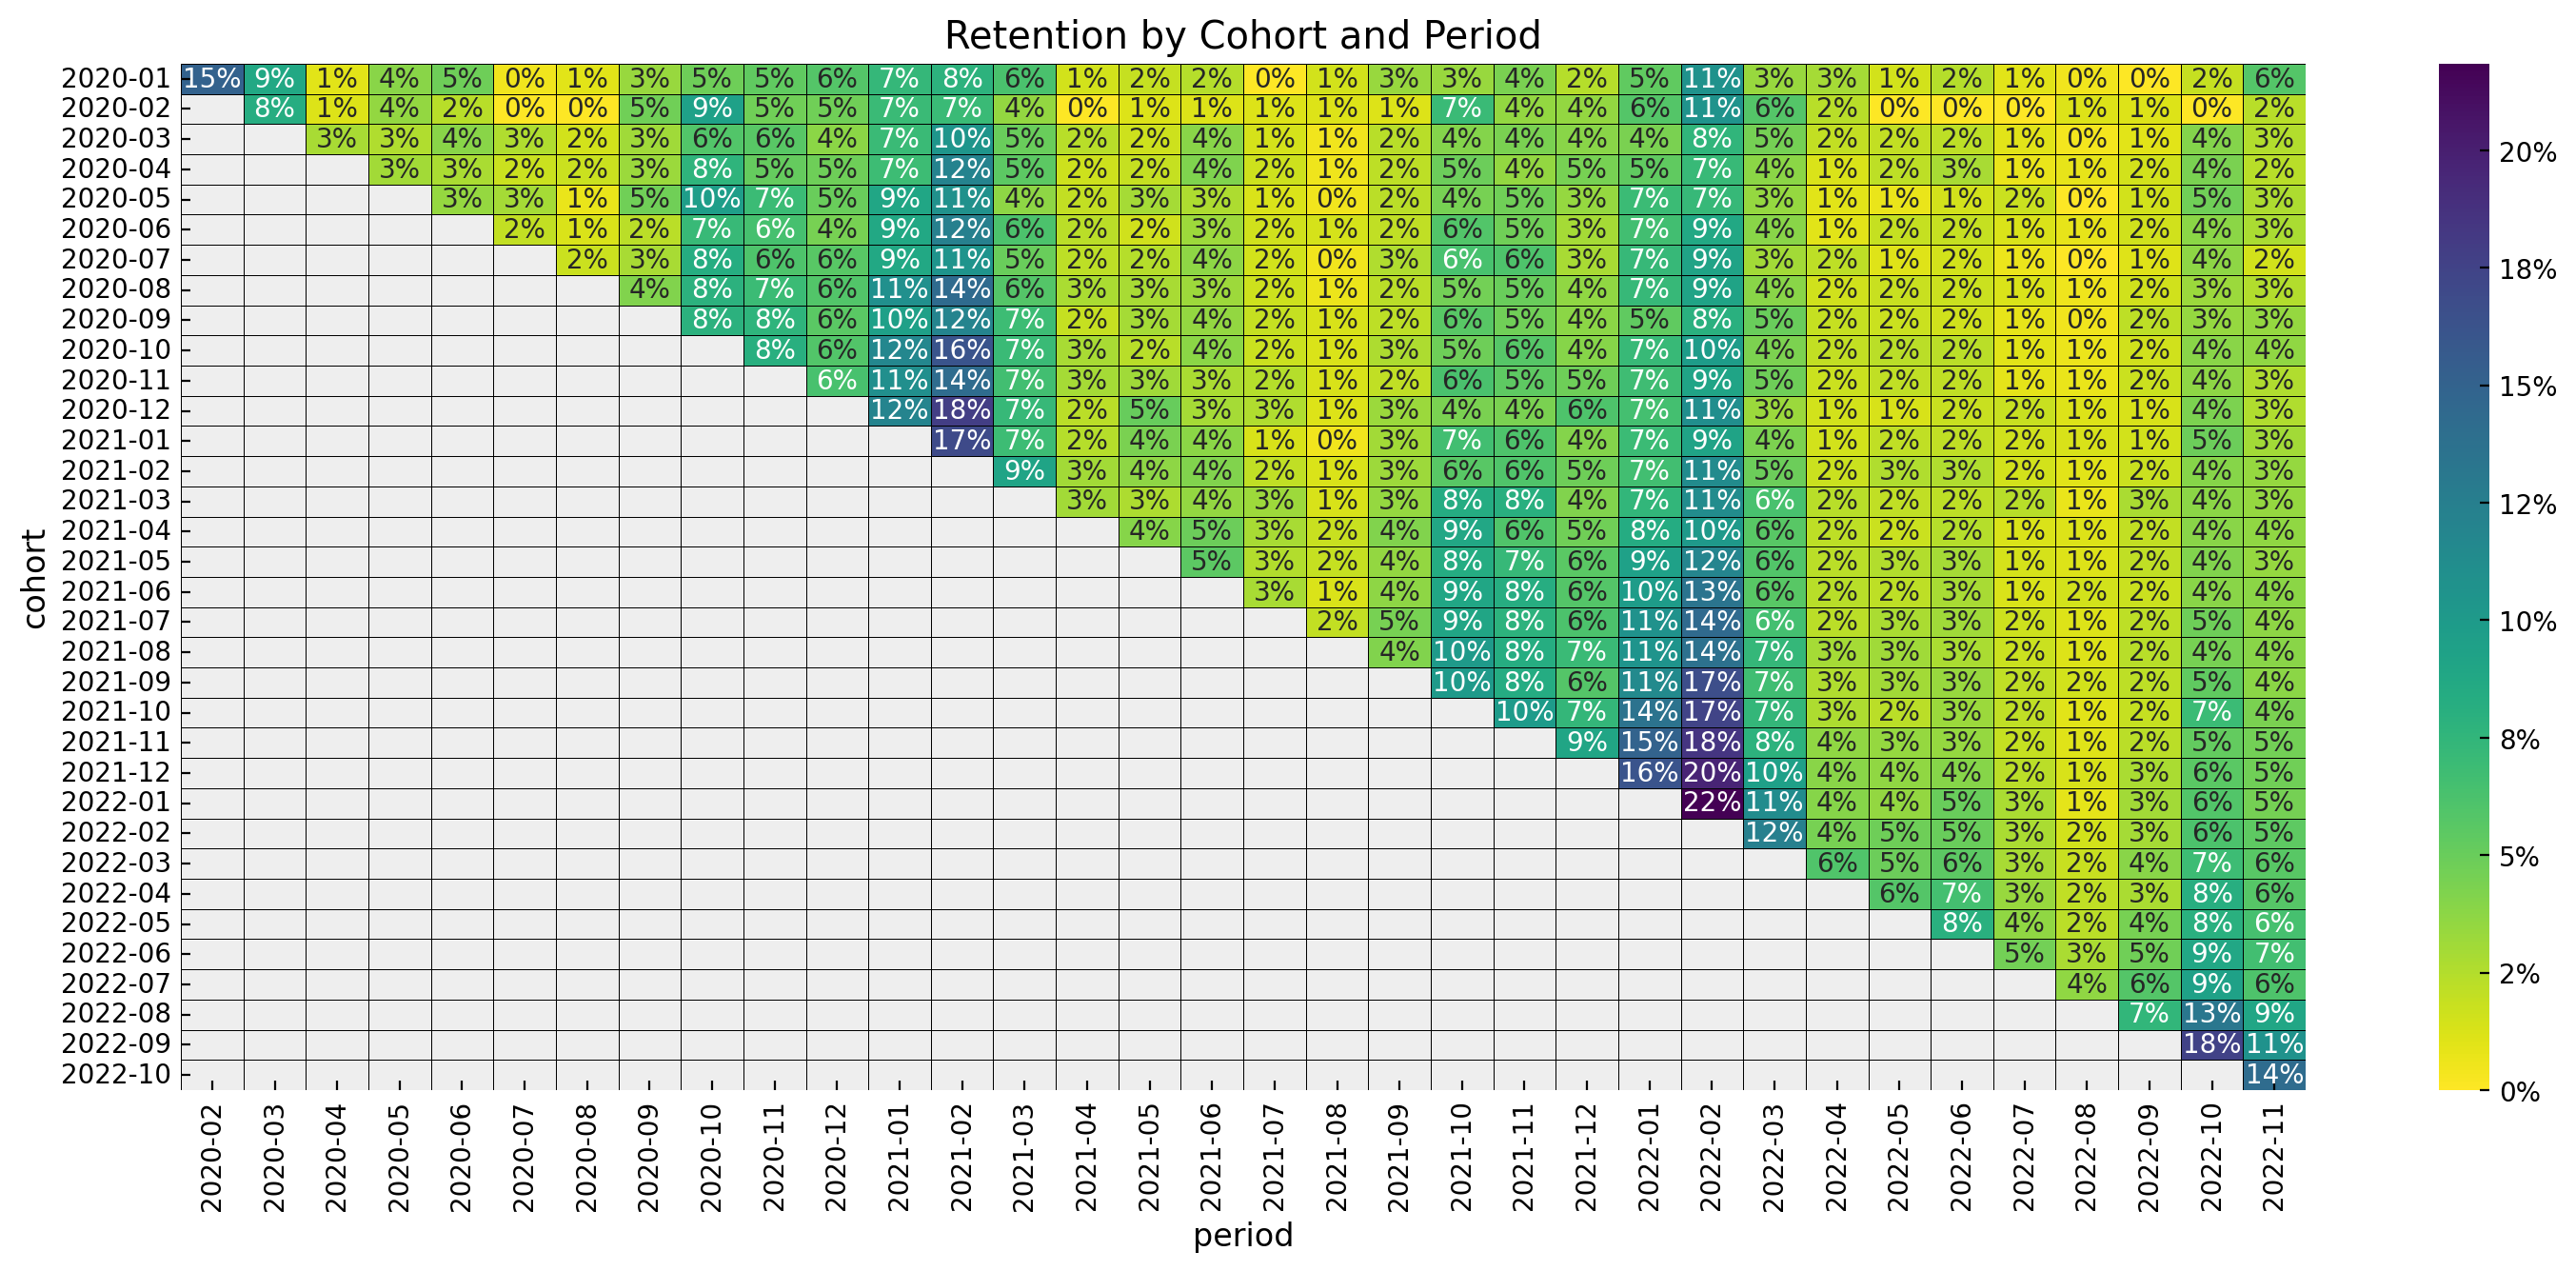

In [5]:
fig, ax = plt.subplots(figsize=(18, 7))

fmt = lambda y, _: f"{y :0.0%}"

(
    data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period");

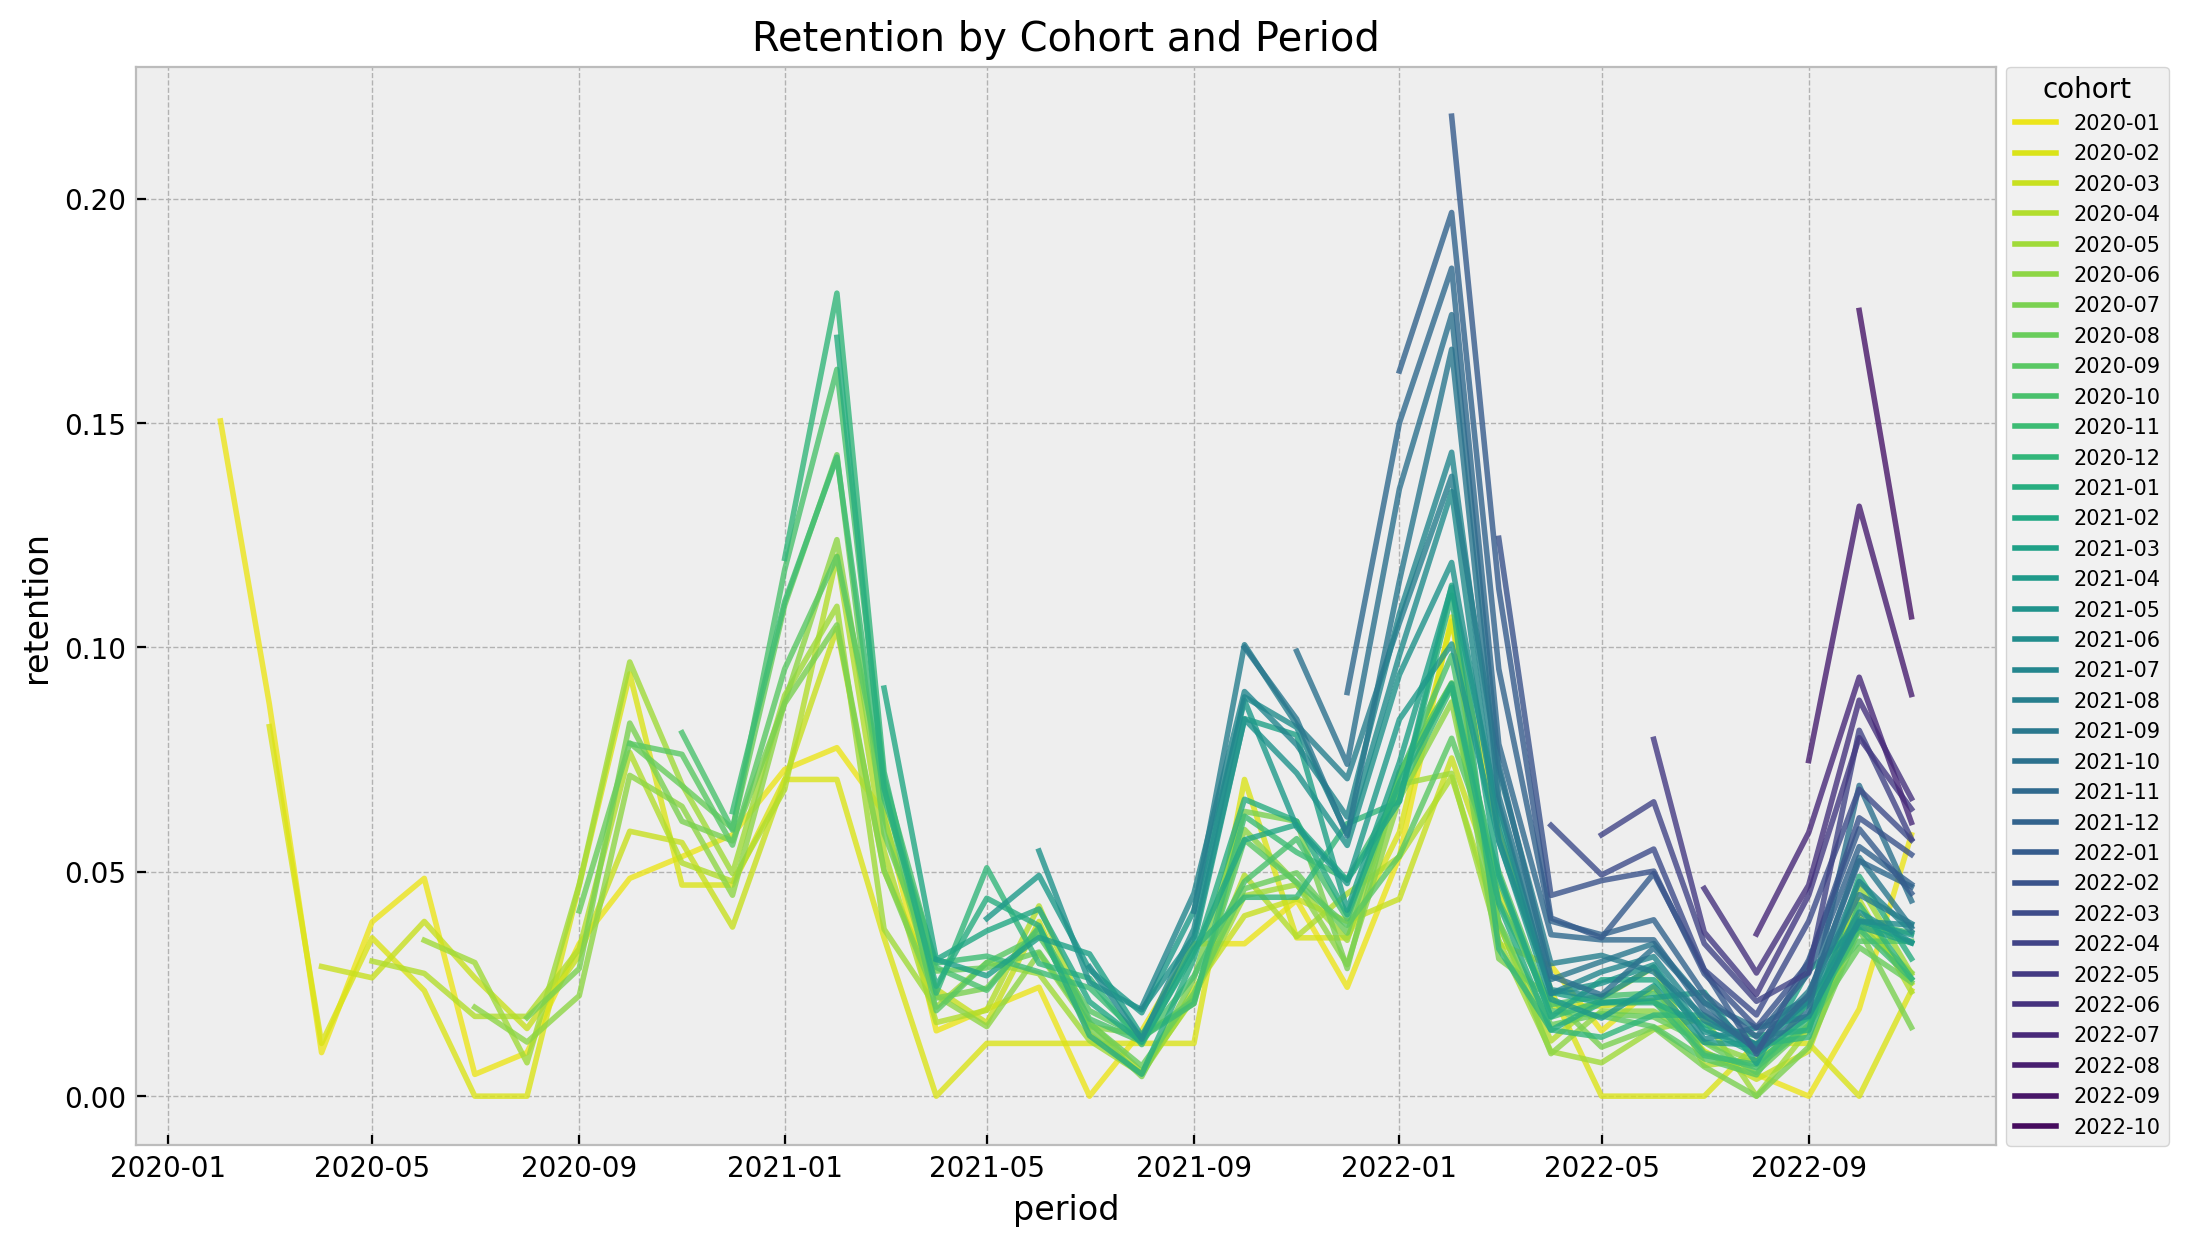

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

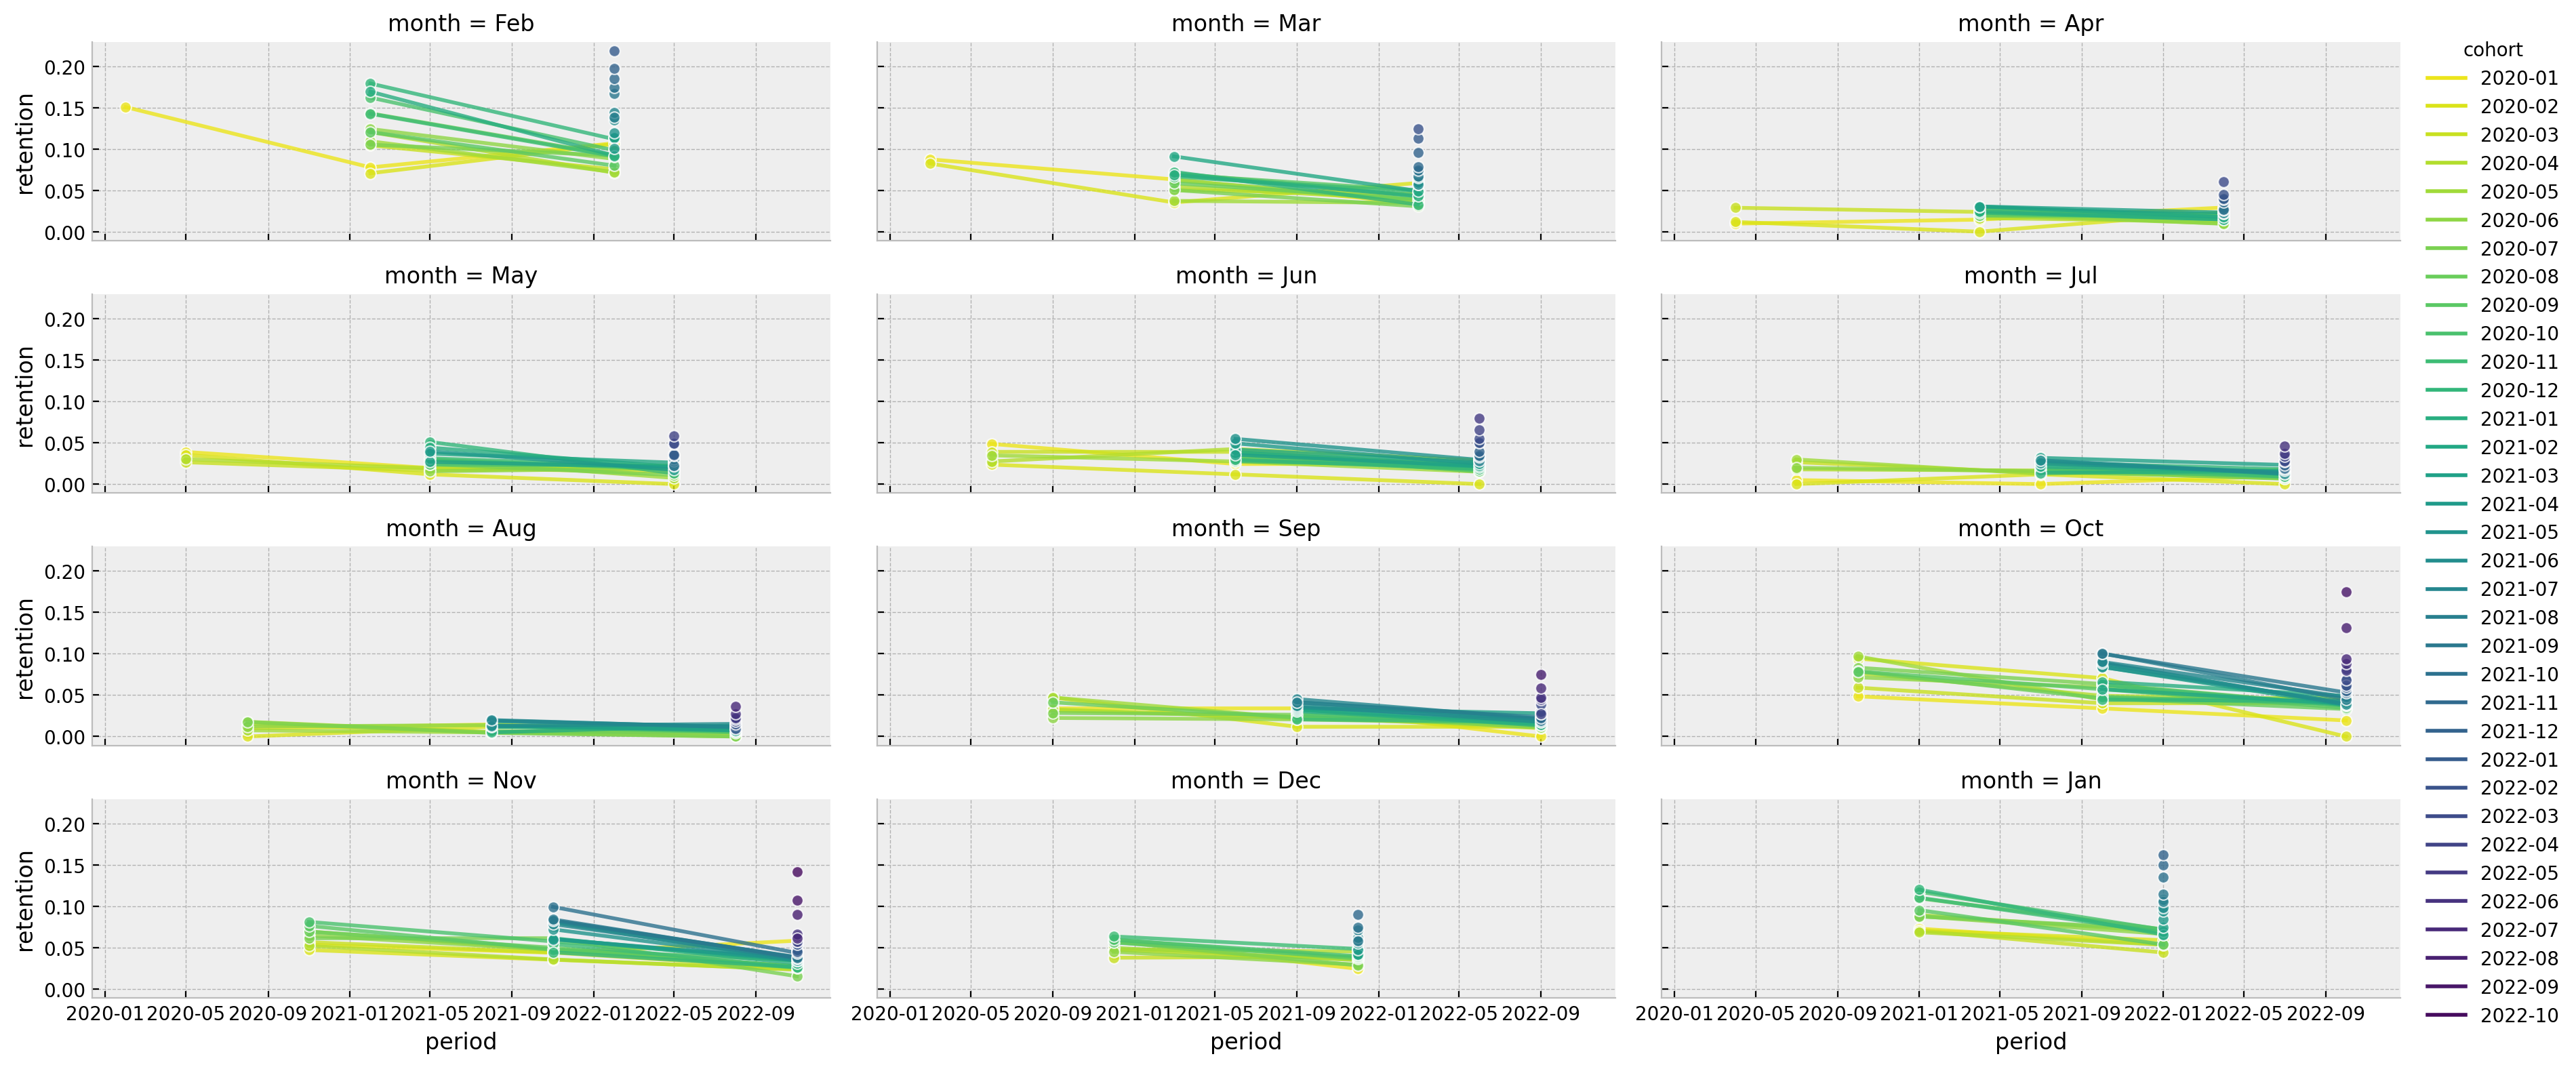

In [7]:
g = sns.relplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    col="month",
    col_wrap=3,
    kind="line",
    marker="o",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        month=lambda df: df["period"].dt.strftime("%b")
    ),
    height=2,
    aspect=3,
    facet_kws={"sharex": True, "sharey": True},
)

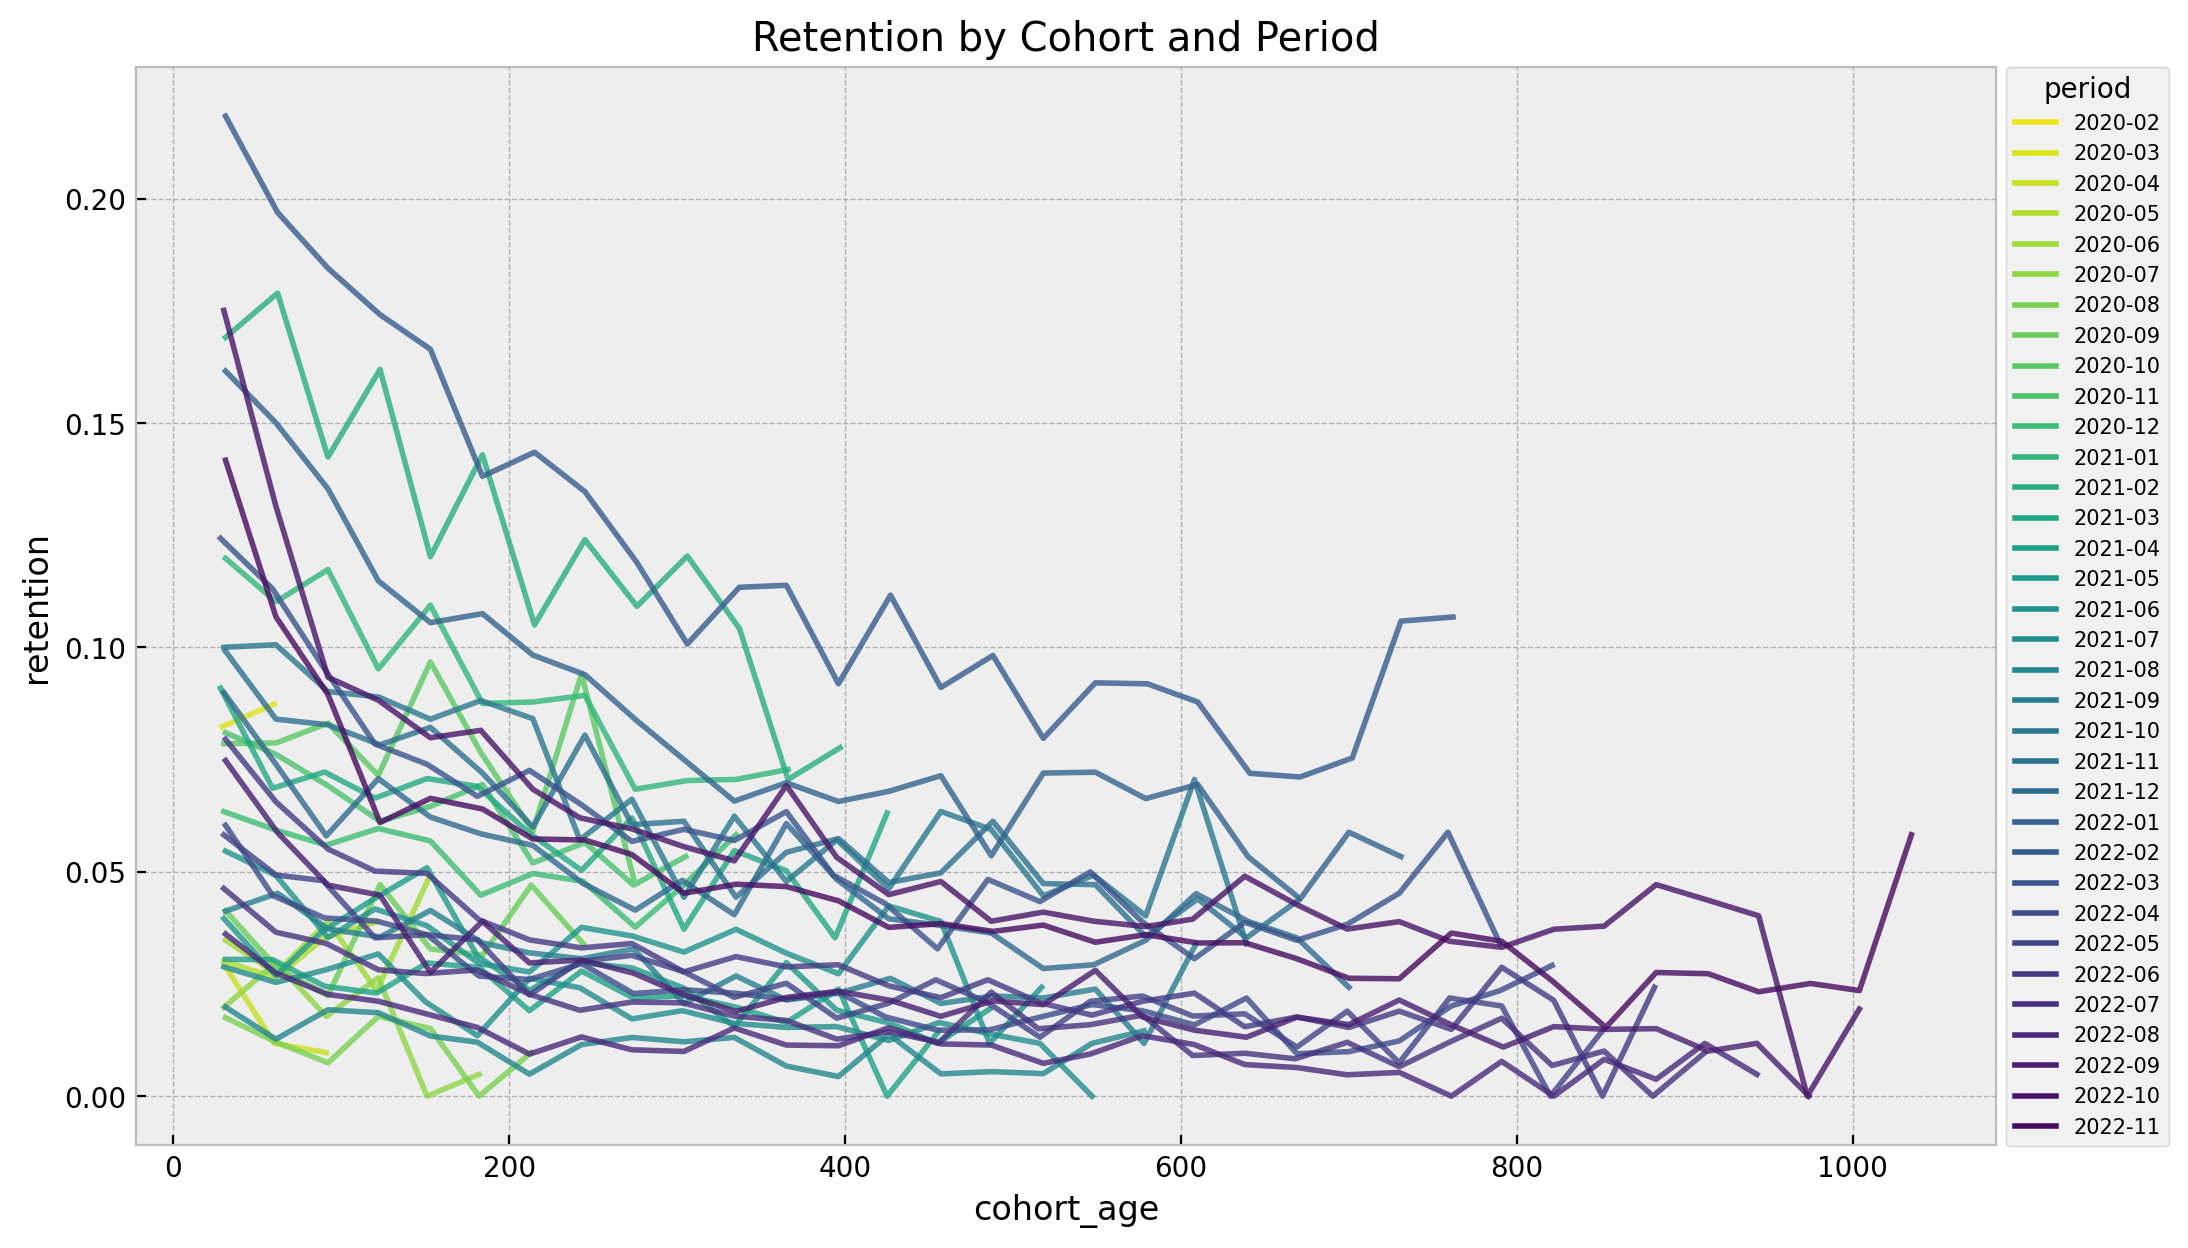

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="cohort_age",
    y="retention",
    hue="period",
    palette="viridis_r",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="period", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

## Model

In [9]:
data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      206 2020-01-01  1035           0          -2.145870   
1 2020-01-01      206 2020-02-01  1035          31          -1.821493   
2 2020-01-01      206 2020-03-01  1035          60          -2.635769   
3 2020-01-01      206 2020-04-01  1035          91          -3.569352   
4 2020-01-01      206 2020-05-01  1035         121          -3.483719   

   retention_true  n_active_users  retention  
0        0.104718             206   1.000000  
1        0.139255              31   0.150485  
2        0.066872              18   0.087379  
3        0.027402               2   0.009709  
4        0.029779               8   0.038835

In [10]:
data_red_df = data_df.query("cohort_age > 0").reset_index(drop=True)
obs_idx = data_red_df.index.to_numpy()
cohort_idx, cohort = data_red_df["cohort"].factorize()
period_idx, period = data_red_df["period"].factorize()
n_users = data_red_df["n_users"].to_numpy()
n_active_users = data_red_df["n_active_users"].to_numpy()
age = data_red_df["age"].to_numpy()
period_month_idx, period_month = data_red_df["period"].dt.strftime("%b").factorize()


coords: dict[str, npt.NDArray] = {
    "obs": obs_idx,
    "cohort": cohort,
    "period": period,
    "period_month": period_month,
}

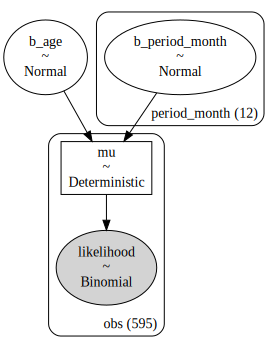

In [11]:
with pm.Model(coords=coords) as model:

    b_age = pm.Normal(name="b_age", mu=0, sigma=1)
    b_period_month = pm.Normal(
        name="b_period_month", mu=0, sigma=1, dims="period_month"
    )

    mu = pm.Deterministic(
        name="mu", var=b_age * age + b_period_month[period_month_idx], dims="obs"
    )

    pm.Binomial(
        name="likelihood",
        n=n_users,
        p=pm.math.invlogit(mu),
        observed=n_active_users,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [17]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=2_000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:03.924426
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:26.487610
Transforming variables...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Transformation time =  0:00:00.235891


In [18]:
az.summary(data=idata, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
b_age               -0.001  0.000  -0.001   -0.001        0.0      0.0   
b_period_month[Feb] -1.111  0.014  -1.138   -1.085        0.0      0.0   
b_period_month[Mar] -1.895  0.016  -1.924   -1.865        0.0      0.0   
b_period_month[Apr] -2.859  0.021  -2.900   -2.820        0.0      0.0   
b_period_month[May] -2.799  0.020  -2.837   -2.762        0.0      0.0   
b_period_month[Jun] -2.543  0.016  -2.573   -2.513        0.0      0.0   
b_period_month[Jul] -3.131  0.018  -3.164   -3.097        0.0      0.0   
b_period_month[Aug] -3.596  0.021  -3.638   -3.558        0.0      0.0   
b_period_month[Sep] -2.852  0.015  -2.881   -2.824        0.0      0.0   
b_period_month[Oct] -2.058  0.011  -2.077   -2.036        0.0      0.0   
b_period_month[Nov] -2.266  0.012  -2.288   -2.244        0.0      0.0   
b_period_month[Dec] -2.071  0.021  -2.111   -2.031        0.0      0.0   
b_period_month[Jan] -1.427  0.015  -1.455   -1.399        0.0      0.0   

                     ess_bulk  ess_tail  r_hat  
b_age                  2626.0    4500.0    1.0  
b_period_month[Feb]    4578.0    5534.0    1.0  
b_period_month[Mar]    5027.0    5149.0    1.0  
b_period_month[Apr]    4861.0    5449.0    1.0  
b_period_month[May]    4836.0    6060.0    1.0  
b_period_month[Jun]    5341.0    5246.0    1.0  
b_period_month[Jul]    3658.0    4694.0    1.0  
b_period_month[Aug]    3116.0    3410.0    1.0  
b_period_month[Sep]    3840.0    4762.0    1.0  
b_period_month[Oct]    4247.0    5785.0    1.0  
b_period_month[Nov]    4558.0    5438.0    1.0  
b_period_month[Dec]    6870.0    5631.0    1.0  
b_period_month[Jan]    4644.0    5510.0    1.0

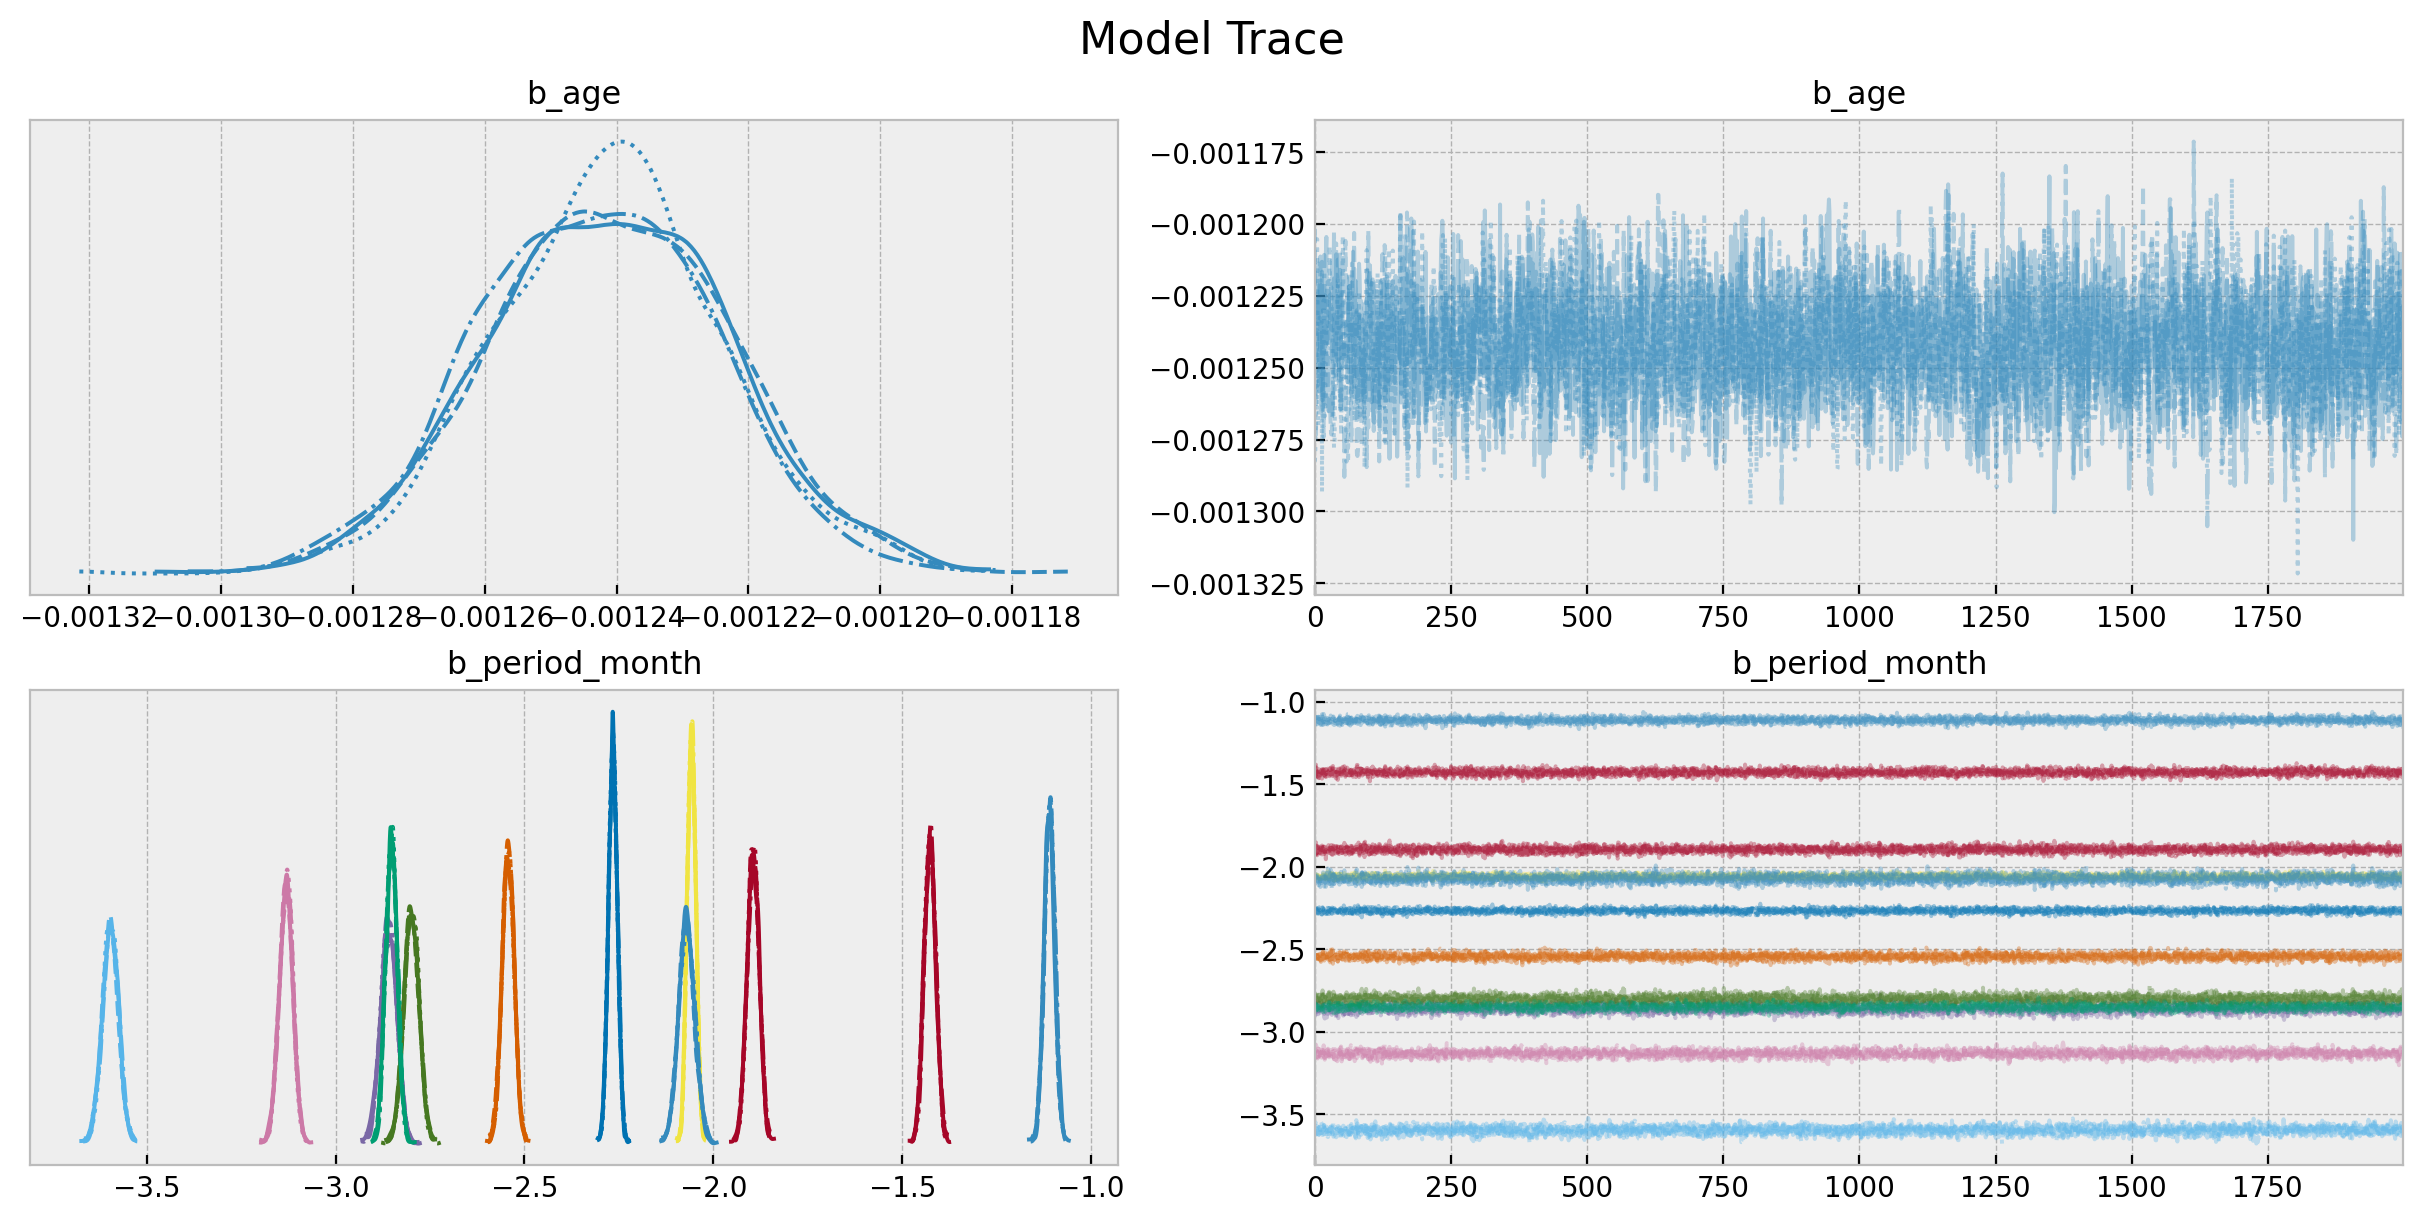

In [19]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu"],
    compact=True,
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

<AxesSubplot: xlabel='likelihood / likelihood'>

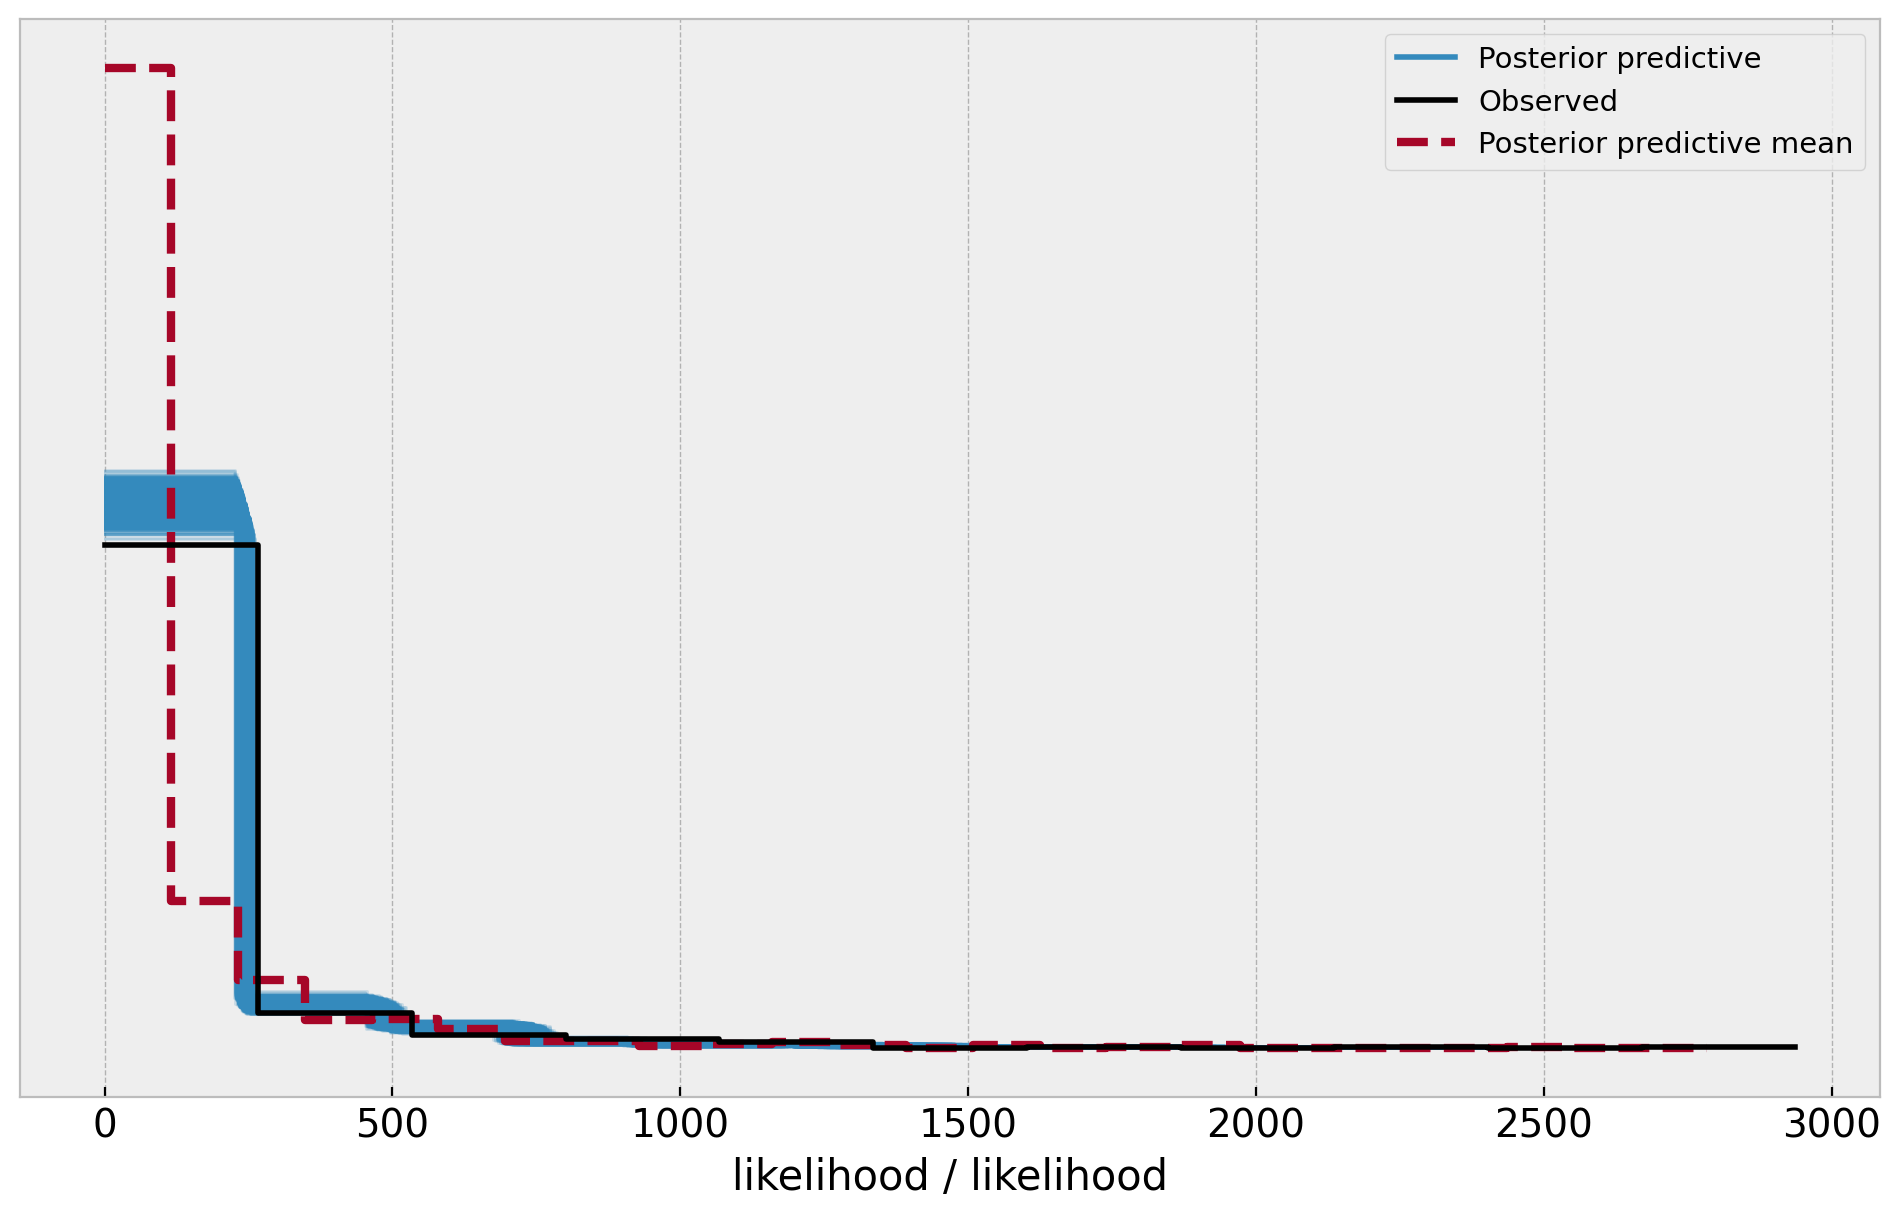

In [20]:
az.plot_ppc(data=posterior_predictive)

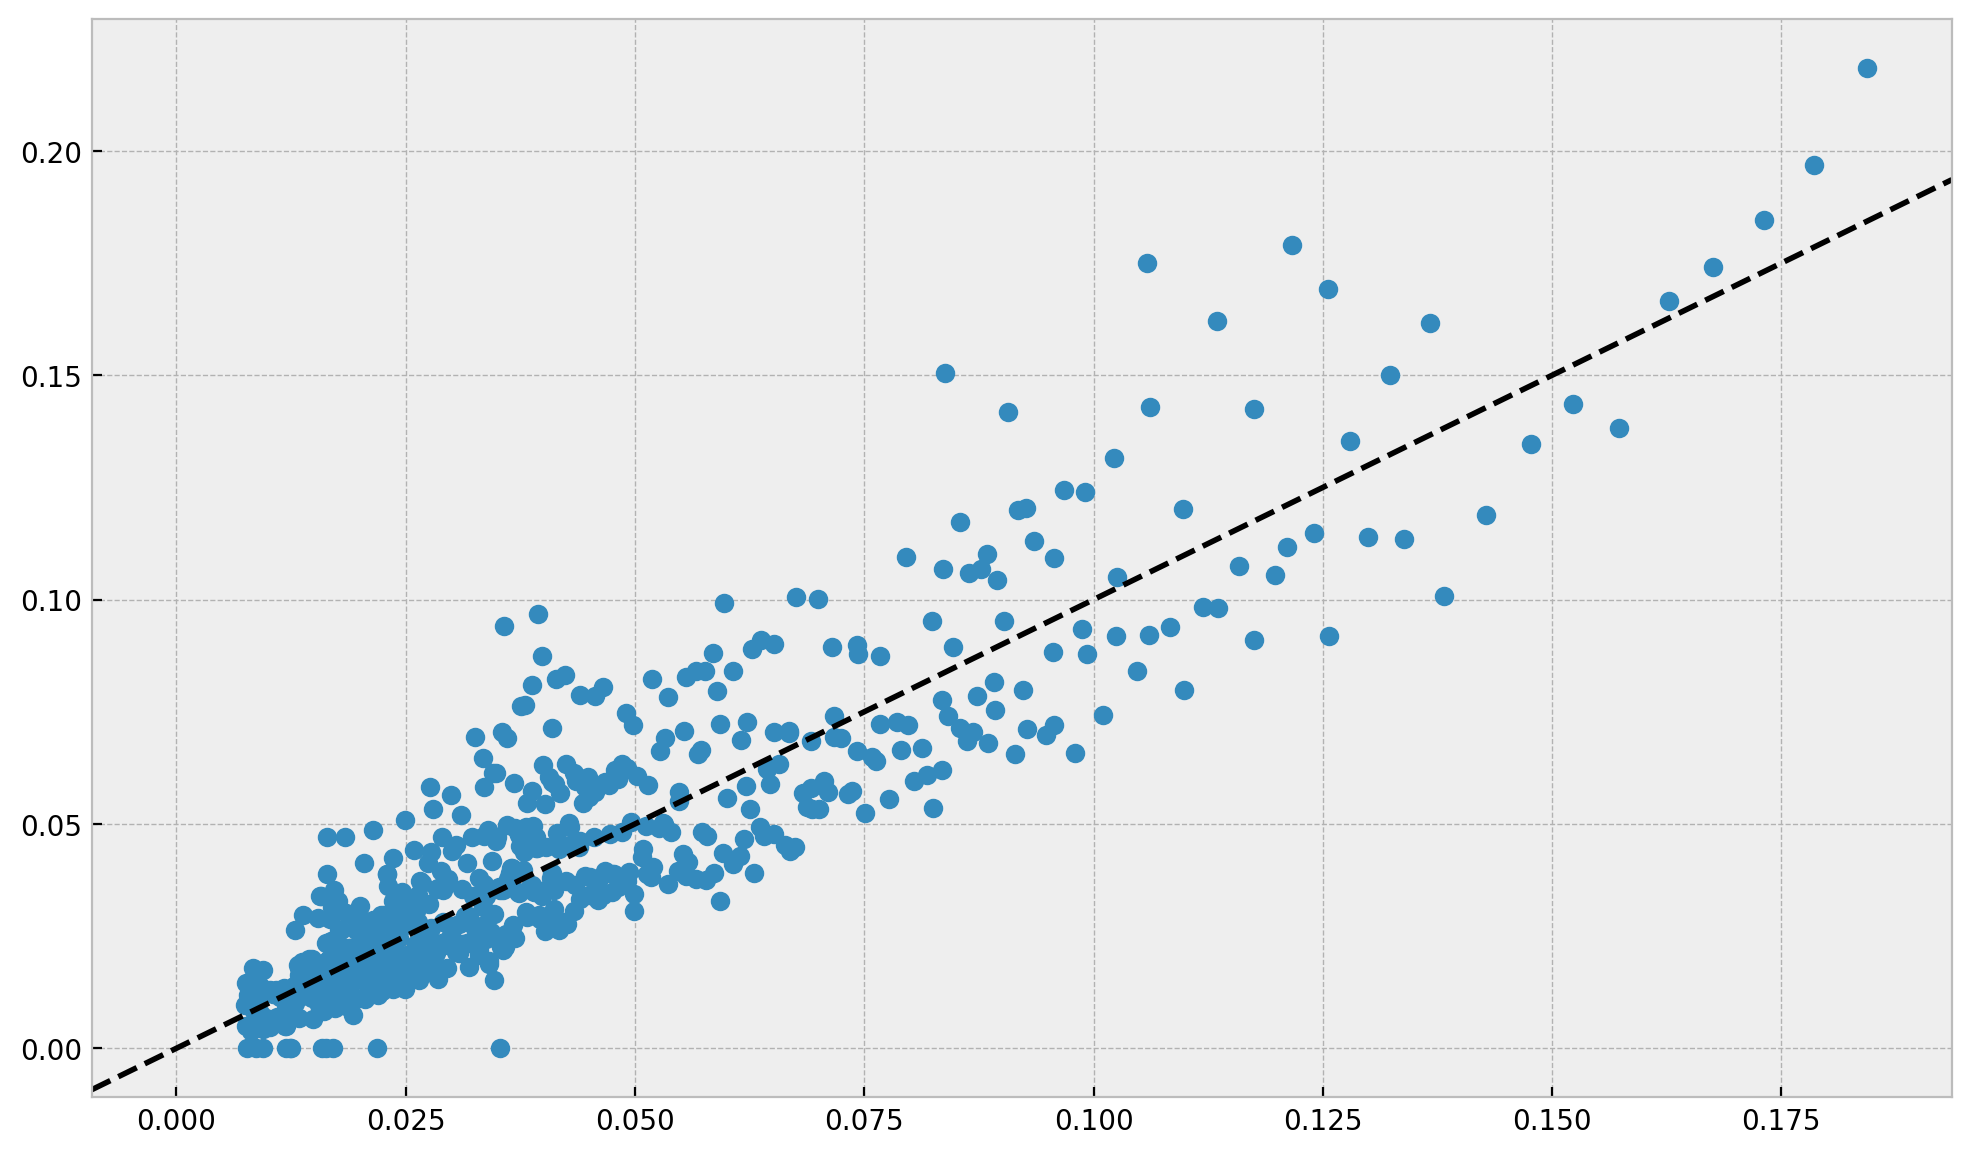

In [21]:
plt.plot((az.extract(data=posterior_predictive, group="posterior_predictive")["likelihood"] / n_users[..., None]).mean(axis=1), data_red_df["retention"], "o")
plt.axline(xy1=(0,0), slope=1, color="black", linestyle="--")